<b>Instructions</b>
1. You should have <i>\_project_root_dir\_/configs/users.csv</i> file. But this file is not allowed to be pushed to this project's GitHub repository. Please ask this script's developer(s) for the file. There is however a template <i>\_project_root_dir\_/configs/users_template.csv</i>.
2. You should have <i>\_project_root_dir\_/images/raw</i> containing image dataset. Images can be at max one subfolder level down to be detected by the script.
3. Run all blocks. Scroll to the bottom. The bottommost contains hyperparameters such as row index start. Below that block is the app display.
4. Input your username as assigned in <i>users.csv</i> which determines what labeling CSV file you are assigned to.
5. Continually label or skip images with appropriate inputs as asked in prompts. All inputs are case-insensitive.
6. To terminate and save changes, use <b>(x)</b> option.
7. To repeat the app, just run the bottommost block. No need to repeat the others. Note: already labeled images in a current user's file are automatically skipped.
8. Changes apply to a user's assigned CSV file only.

In [1]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pandas as pd
import os

In [37]:
class ImageClassUpdater:
    root_dir = ".."
    
    def __init__(self, statuses_csv="tracker\\tracker.csv", images_folder="images\\raw", start_index=1):
        self.statuses_csv = os.path.join(self.root_dir, statuses_csv)
        self.images_folder = os.path.join(self.root_dir, images_folder)
        self.start_index = start_index
        self.users_config = os.path.join(self.root_dir, "configs\\users.csv")
        self.classes_config = os.path.join(self.root_dir, "configs\\pomelo_classes.csv")
        self.labeling_csv = None
        self.username = None
        self.images_data = None
        self.pomelo_classes = {}
        
        self.validate_inputs()
        self.load_configs()
        self.prepare_images_data()
    
    def validate_inputs(self):
        """Validate input parameters and files"""
        if self.start_index < 1:
            raise ValueError("start_index must be at least 1")
        
        if not os.path.exists(self.statuses_csv):
            raise FileNotFoundError(f"Statuses CSV file not found: {self.statuses_csv}")
        
        if not os.path.exists(self.images_folder):
            raise FileNotFoundError(f"Images folder not found: {self.images_folder}")
    
    def load_configs(self):
        """Load users and classes configuration"""
        # Load users config
        if not os.path.exists(self.users_config):
            raise FileNotFoundError(f"Users config file not found: {self.users_config}")
        
        users_df = pd.read_csv(self.users_config)
        self.prompt_username(users_df)
        
        # Load classes config
        if not os.path.exists(self.classes_config):
            raise FileNotFoundError(f"Classes config file not found: {self.classes_config}")
        
        classes_df = pd.read_csv(self.classes_config)
        self.pomelo_classes = {
            row['Name']: str(row.get('Included in Class Updater', 'FALSE')).upper() == 'TRUE'
            for _, row in classes_df.iterrows()
        }
    
    def prompt_username(self, users_df):
        """Simple synchronous username prompt that works in notebooks"""
        while True:
            username = input("Enter your username: ").strip()
            if not username:
                print("Username cannot be empty. Please try again.\n")
                continue
            
            # Case-insensitive matching
            matching_users = users_df[users_df['Name'].str.lower() == username.lower()]
            
            if not matching_users.empty:
                self.username = matching_users.iloc[0]['Name']
                self.labeling_csv = os.path.join(self.root_dir, matching_users.iloc[0]['Labeling File Path'])
                print(f"Welcome, {self.username}!")
                print(f"Labeling file: {self.labeling_csv}\n")
                
                # Check file permissions
                if not os.path.exists(self.labeling_csv):
                    raise FileNotFoundError(f"Labeling CSV file not found: {self.labeling_csv}")
                
                try:
                    with open(self.labeling_csv, 'r+') as f:
                        pass
                except PermissionError:
                    raise PermissionError(f"No write permission for labeling CSV: {self.labeling_csv}")
                
                break
            else:
                print("Invalid username. Please try again.\n")
    
    def validate_csv_files(self):
        """Validate that statuses and labeling CSV files have matching structure"""
        statuses_df = pd.read_csv(self.statuses_csv)
        labeling_df = pd.read_csv(self.labeling_csv)
        
        # Check row count (excluding headers)
        if len(statuses_df) != len(labeling_df):
            raise ValueError(f"Row count mismatch: statuses CSV has {len(statuses_df)} rows, labeling CSV has {len(labeling_df)} rows")
        
        # Check if Name columns match exactly
        if not statuses_df['Name'].equals(labeling_df['Name']):
            raise ValueError("Name columns in statuses and labeling CSV files do not match")
        
        # Validate start_index bounds
        if self.start_index > len(labeling_df):
            raise ValueError(f"start_index {self.start_index} exceeds maximum row index {len(labeling_df)}")
        
        return statuses_df, labeling_df
    
    def find_image_file(self, image_name):
        """Find image file in images folder (direct and one subfolder level down)"""
        # Search in root images folder
        for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp']:
            file_path = os.path.join(self.images_folder, image_name + ext)
            if os.path.exists(file_path):
                return file_path
        
        # Search in subfolders (one level down)
        for subdir in os.listdir(self.images_folder):
            subdir_path = os.path.join(self.images_folder, subdir)
            if os.path.isdir(subdir_path):
                for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp']:
                    file_path = os.path.join(subdir_path, image_name + ext)
                    if os.path.exists(file_path):
                        return file_path
        
        return None
    
    def prepare_images_data(self):
        """Prepare tuple of image data dictionaries"""
        statuses_df, labeling_df = self.validate_csv_files()
        
        images_data = []
        for idx in range(self.start_index - 1, len(statuses_df)):  # Convert to 0-based index
            image_name = statuses_df.iloc[idx]['Name']
            status = statuses_df.iloc[idx]['Status'] if 'Status' in statuses_df.columns else ''
            class_name = labeling_df.iloc[idx]['Class']
            
            file_path = self.find_image_file(image_name)
            
            images_data.append({
                'row_index': idx + 1,  # Convert back to 1-based for display
                'image_name': image_name,
                'file_path': file_path,
                'status': status,
                'class': class_name,
                'df_index': idx  # Store the actual DataFrame index for updating
            })
        
        self.images_data = tuple(images_data)
        print(f"Prepared {len(images_data)} images for processing (starting from index {self.start_index})")


In [45]:
def run_updater(statuses_csv="tracker\\tracker.csv", images_folder="images\\raw", start_index=1):
    try:
        updater = ImageClassUpdater(statuses_csv, images_folder, start_index)
        
        if not updater.images_data:
            print("No images to process.")
            return
        
        updated_count = 0
        labeling_df = pd.read_csv(updater.labeling_csv)
        valid_classes = [cls for cls, included in updater.pomelo_classes.items() if included]
        
        for image_data in updater.images_data:
            clear_output(wait=True)
            
            # Skip conditions
            if image_data['status'] == 'Unusable':
                print(f"Skipping '{image_data['image_name']}' - Unusable")
                continue
            
            if image_data['class'] not in updater.pomelo_classes:
                raise ValueError(f"Invalid class '{image_data['class']}' for image '{image_data['image_name']}'")
            
            if updater.pomelo_classes[image_data['class']]:
                print(f"Skipping '{image_data['image_name']}' - class '{image_data['class']}' is valid")
                continue
            
            # Display image
            print(f"Row {image_data['row_index']}/{len(updater.images_data) + updater.start_index - 1}: {image_data['image_name']}")
            print(f"Current Class: {image_data['class']}")
            
            if image_data['file_path'] and os.path.exists(image_data['file_path']):
                img = plt.imread(image_data['file_path'])
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.title(f"{image_data['image_name']}\nCurrent: {image_data['class']}")
                plt.axis('off')
                plt.show()
            else:
                print(f"Image not found: {image_data['file_path']}")
            
            # Display options
            print("\nOptions:")
            for i, class_name in enumerate(valid_classes, 1):
                print(f"({i}) {class_name}")
            print(f"({len(valid_classes) + 1}) Skip")
            print("(x) Terminate")
            
            while True:
                choice = input("\nSelect option: ").strip().lower()
                
                if choice == 'x':
                    if input("Confirm termination? (y/n): ").lower() == 'y':
                        if updated_count > 0:
                            labeling_df.to_csv(updater.labeling_csv, index=False)
                            print(f"Saved {updated_count} updates to: {updater.labeling_csv}")
                        else:
                            print("No changes made")
                        return
                    continue
                
                if choice == str(len(valid_classes) + 1):
                    print("Skipped")
                    break
                
                if choice.isdigit() and 1 <= int(choice) <= len(valid_classes):
                    new_class = valid_classes[int(choice) - 1]
                    if input(f"Change to '{new_class}'? (y/n): ").lower() == 'y':
                        labeling_df.at[image_data['df_index'], 'Class'] = new_class
                        updated_count += 1
                        print(f"Updated to {new_class}")
                        break
                    else:
                        continue
                else:
                    print("Invalid option")
        
        if updated_count > 0:
            labeling_df.to_csv(updater.labeling_csv, index=False)
            print(f"Completed! Saved {updated_count} updates to: {updater.labeling_csv}")
        else:
            print("No changes made")
            
    except Exception as e:
        print(f"Error: {e}")

Row 120/1557: IMG20250703084935
Current Class: Unlabeled


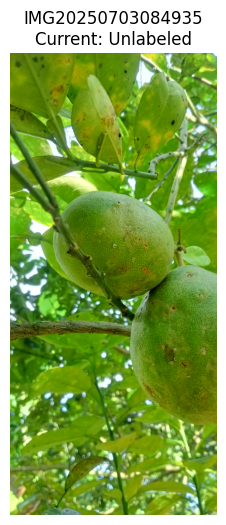


Options:
(1) Anthracnose
(2) Borer
(3) Canker
(4) Healthy
(5) Mites
(6) Multiple
(7) Skip
(x) Terminate
No changes made


In [46]:
def app():
    statuses_csv = "tracker\\tracker.csv"
    images_folder = "images\\raw"
    start_index = 120
    print(statuses_csv)
    run_updater(statuses_csv, images_folder, start_index)
app()